In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [32]:
data = pd.read_csv('./dynamic_pricing.csv')

## EDA

In [33]:
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [34]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [35]:
data.shape

(1000, 10)

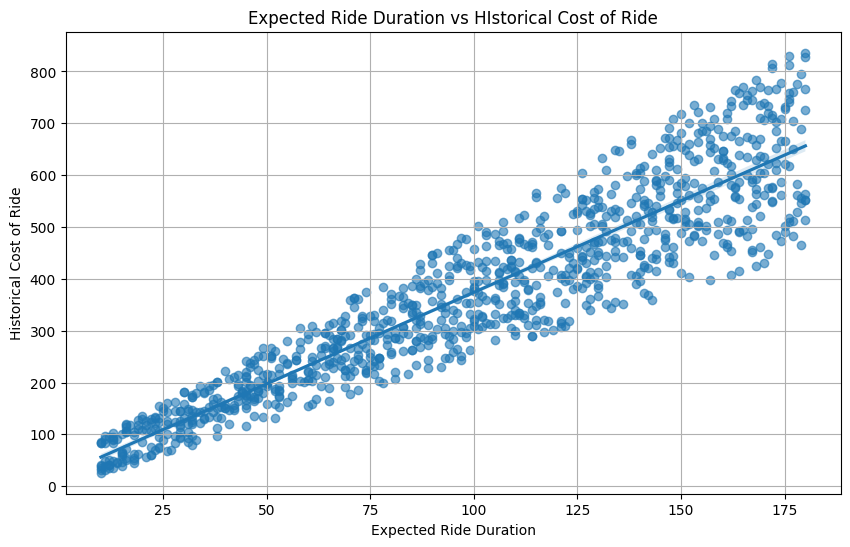

In [36]:
# Relationship Between Expected Ride Duration and Historical Cost of Ride

plt.figure(figsize=(10,6))
plt.scatter(data['Expected_Ride_Duration'], data['Historical_Cost_of_Ride'], label='Data', alpha=0.6)
sns.regplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', data=data, scatter=False, label='OLS Trendline')
plt.title('Expected Ride Duration vs HIstorical Cost of Ride')
plt.xlabel('Expected Ride Duration')
plt.ylabel('Historical Cost of Ride')
plt.grid()
plt.show()

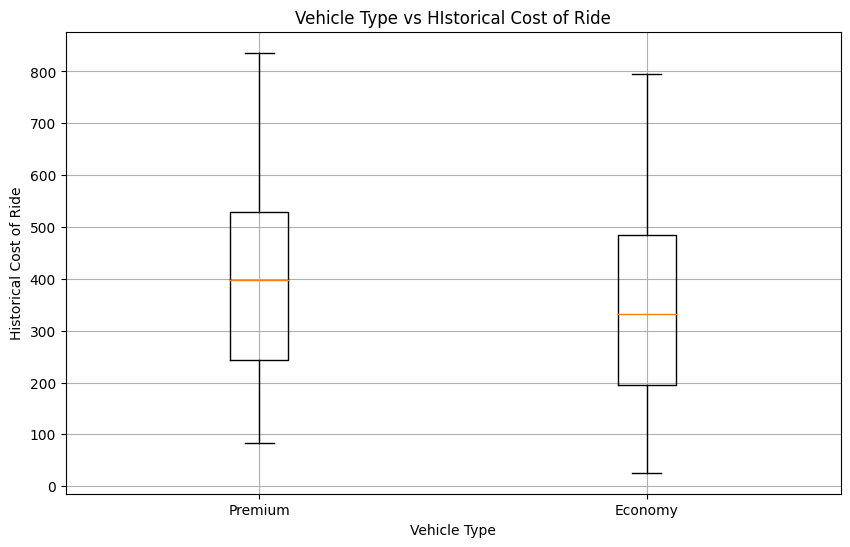

In [37]:
# Relationship Between Vehicle Type and Historical Cost of Ride
premium_vehicle = data[data['Vehicle_Type'] == 'Premium']
economy_vehicle = data[data['Vehicle_Type'] == 'Economy']
plt.figure(figsize=(10,6))
plt.boxplot([data[data['Vehicle_Type'] == 'Premium']['Historical_Cost_of_Ride'],
           data[data['Vehicle_Type'] == 'Economy']['Historical_Cost_of_Ride']], labels=['Premium','Economy'])
plt.title('Vehicle Type vs HIstorical Cost of Ride')
plt.xlabel('Vehicle Type')
plt.ylabel('Historical Cost of Ride')
plt.grid()
plt.show()

In [38]:
data['Vehicle_Type'].unique()

array(['Premium', 'Economy'], dtype=object)

In [39]:
# Correlation Matrix
filter = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration','Historical_Cost_of_Ride']
selected_df = data[filter]
corr_matrix = selected_df.corr()

fig = go.Figure(data=go.Heatmap(z=corr_matrix.values, 
                                x=corr_matrix.columns, 
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix')
fig.show()

### Implementing Dynamic Pricing Strategy

In [40]:
import numpy as np

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [41]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]





In [42]:
# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.5)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

### Training a Predictive Model



In [44]:
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    num_f = data.select.dtypes(include=['float', 'int']).columns
    cat_f = data.select.dtypes(include=['object']).columns

    #Handle missing values in numerical features
    data[num_f] = data[num_f].fillna(data[numf].mean())

    #Detect and handle outliers in numerical features using IQR
    for f in num_f:
        Q1 = data[f].quantile(0.25)
        Q3 = data[f].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[f] = np.where((data[f] < lower_bound) | (data[f] > upper_bound), data[f].mean(), data[f])

    # Handle missing values in categorical features
    data[cat_f] = data[cat_f].fillna(data[cat_f].mode().iloc[0])

    return data

In [45]:
# Encoding vehicle type
data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy':0})

In [46]:
# Splitting the data
from sklearn.model_selection import train_test_split

x = np.array(data[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Expected_Ride_Duration']])
y = np.array(data[['adjusted_ride_cost']])

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


#Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_train.ravel()

#Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train,y_train)

RandomForestRegressor()

## Testing the model

In [48]:
y_pred = model.predict(x_test)
print(y_pred)

[ 505.69091228  793.02860972  890.78014051  734.61178149  240.8785196
 1056.33966237  309.87157848  204.26638852  500.0710369   212.09274703
  634.31884263  381.529254    113.28136693 1545.86078023  385.76543946
  750.65352535 1110.1085836   430.33182779  478.09374415  729.72777462
  970.40047839  113.75360469  253.75758717  596.62305916  570.95455858
 1348.82805518  232.6936661   968.69704664  477.53280513 1165.72651294
  574.1048194   189.84898977  699.79227738  310.47159003 1032.88690837
  547.10274945  392.74021704  279.1484114   389.67912819  307.15586592
 1022.61801848 1335.72390186  934.49791332 1475.84844631 1343.40531781
  489.67207251  762.90253036 1626.46419949  495.79782591 1249.98159652
 1123.20388126  447.38609783  906.05529941  514.43482461  509.57336209
  402.82443013  336.11801653 1593.23537022 1359.58008643  614.07202846
 1194.75612876  871.25696287  847.47150357  937.98767925 1816.31197062
  593.4100015   416.81297938  315.8526193   784.20953913  233.92053111
  484.8

In [55]:
# Creating a scatter plot with actual and predicted values

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# Add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
    )

fig.show()